In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path #pour manipuler facilement les chemins des fichiers
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [119]:
dt= xr.open_dataset('/home/nmpnguyen/giems2_wgs84_v2.nc', decode_cf=False)

In [121]:
dt['Wetland area']

<xarray.DataArray 'Wetland area' (Time: 288, latitude: 720, longitude: 1440)>
[298598400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * Time       (Time) int32 1 2 3 4 5 6 7 8 ... 281 282 283 284 285 286 287 288
Attributes:
    units:      km^2
    long_name:  Wetland area in each 0.25deg grid cell (km^2)

In [64]:
dt = xr.open_dataset('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200514/elic_355_concat_data.nc')
dt

<xarray.Dataset>
Dimensions:                                           (channel: 1, level: 4000, time: 87)
Coordinates:
    altitude                                          (time, level) float64 ...
  * time                                              (time) datetime64[ns] 2...
Dimensions without coordinates: channel, level
Data variables:
    temperature                                       (time, level) float64 ...
    pressure                                          (time, level) float64 ...
    attenuated_backscatter                            (channel, time, level) float64 ...
    molecular_extinction                              (channel, time, level) float64 ...
    molecular_transmissivity_at_emission_wavelength   (channel, time, level) float64 ...
    molecular_transmissivity_at_detection_wavelength  (channel, time, level) float64 ...

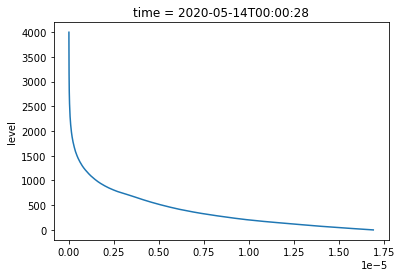

In [71]:
fig, ax = plt.subplots()
(dt['molecular_extinction']*0.119*2*dt['molecular_transmissivity_at_emission_wavelength']).isel(channel=0, time=0).plot(y='level', label='emission', ax=ax)
# dt['molecular_transmissivity_at_detection_wavelength'].isel(channel=0, time=0).plot(y='level', label='detection', ax=ax)


In [56]:
elic = np.array(['temperature', 'pressure', 'attenuated_backscatter', 'molecular_extinction', 'molecular_transmissivity_at_emission_wavelength', 'molecular_transmissivity_at_detection_wavelength'])
elic[np.isin(elic, list(dt.keys()))]

dt[elic[np.isin(elic, list(dt.keys()))]]

<xarray.Dataset>
Dimensions:                 (channel: 2, level: 1050, time: 118)
Coordinates:
    altitude                (time, level) float64 ...
  * time                    (time) datetime64[ns] 2020-04-02T01:00:26 ... 202...
Dimensions without coordinates: channel, level
Data variables:
    attenuated_backscatter  (channel, time, level) float64 ...
Attributes: (12/34)
    Conventions:                          CF-1.7
    title:                                high resolution SCC product
    source:                               lidar surface observation
    references:                           G. D'Amico, A. Amodeo, H. Baars, I....
    location:                             Palaiseau, France
    station_ID:                           sir
    ...                                   ...
    processor_name:                       elic
    processor_version:                    1.0.7
    history:                              2021-07-04T10:32:08Z: elic -d sccop...
    __file_format_version:                1.2
    data_processing_institution:          Consiglio Nazionale delle Ricerche ...
    input_file:                           sir_009_0000987_202004020100_202004...

-----------------------

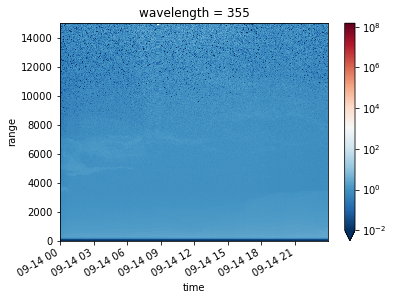

In [2]:
listfiles = sorted(Path('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020').glob('ipral*.nc'))

dt = xr.open_dataset(listfiles[60])
mask = np.logical_and(dt['flags'].sel(wavelength=355).values == 0, dt['flags'].sel(wavelength=532).values == 0)

sr355 = (dt['calibrated']/dt['simulated']).isel(wavelength = 0)
sr355.plot(x='time', y='range', norm=LogNorm(vmin=1e-2), ylim=(0, 15000))

In [37]:
listfiles = sorted(Path('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/').glob('ipral*.nc'))
listdays = ['20200207' , '20200401' , '20200912' , '20200914' , '20200916' , '20200921' , '20200923' , '20201128' ,
'20200326' , '20200911' , '20200913' , '20200915' , '20200918' , '20200922' , '20201105']

allsr355 = None
allsr532 = None

# for file in listfiles:
#     print(file)
#     dt = xr.open_dataset(file)

for f in listdays:
    file = Path('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/', f'ipral_1a_Lz1R15mF30sPbck_v01_{f}_000000_1440.nc')
    dt = xr.open_dataset(file)
    mask = np.logical_and(dt['flags'].sel(wavelength=355).values == 0, dt['flags'].sel(wavelength=532).values == 0)
    zlim = (dt['range'] < 15000)
    if mask.any():
        sr355 = (dt['calibrated']).isel(wavelength = 0, time = mask, range = zlim).resample(time='5min').mean(dim = 'time')
        sr532 = (dt['calibrated']).isel(wavelength = 1, time = mask, range = zlim).resample(time='5min').mean(dim = 'time')
        if allsr355 is None : 
            allsr355 = sr355
            allsr532 = sr532
        else:
            allsr355 = xr.concat([allsr355, sr355], dim='time')
            allsr532 = xr.concat([allsr532, sr532], dim='time')
    else:
        print('Any data to compute !')
        print(mask)
        

In [38]:
allsr355

<xarray.DataArray 'calibrated' (time: 2982, range: 999)>
array([[ 4.87846972e-12,  2.59510248e-11,  2.76757268e-09, ...,
         7.30482776e-07, -1.10441071e-09,  1.22907901e-06],
       [ 5.11929150e-12,  2.08094801e-11,  2.88064242e-09, ...,
         3.46060117e-07,  4.22359326e-09,  6.48754771e-07],
       [ 5.50715686e-12,  2.02704341e-11,  2.83317805e-09, ...,
         7.33535173e-07,  2.45911335e-07,  6.61624921e-07],
       ...,
       [ 3.57462513e-12,  1.50212390e-11,  2.09112054e-09, ...,
         3.39166874e-07,  6.58156847e-07, -3.51367620e-07],
       [ 3.84386679e-12,  1.52100155e-11,  1.97940865e-09, ...,
         4.24804438e-07,  4.67242830e-07,  4.27414187e-07],
       [ 4.29283311e-12,  1.52666617e-11,  1.84358347e-09, ...,
         1.88213755e-07,  1.09046162e-06,  3.40738737e-07]])
Coordinates:
  * time        (time) datetime64[ns] 2020-02-06T23:55:00 ... 2020-11-05T23:5...
  * range       (range) float32 15.0 30.0 45.0 ... 1.496e+04 1.497e+04 1.498e+04
    wavelength  int64 355

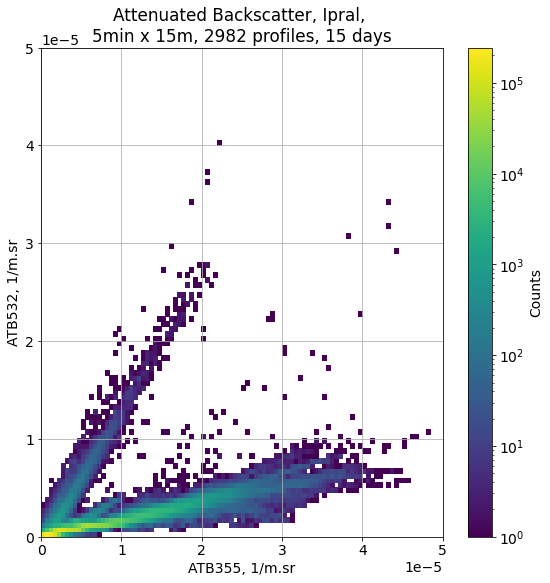

In [39]:
fig, ax = plt.subplots(figsize=(9,9))
plt.rcParams['font.size']=14
ranges = [[0,5e-5], [0,5e-5]] #[[-1, 50], [-1, 50]]#

h= ax.hist2d(allsr355.values.ravel(), allsr532.values.ravel(), range=ranges, 
         bins=100, norm=LogNorm())
plt.colorbar(h[3], ax=ax, label='Counts')
ax.set(xlabel='ATB355, 1/m.sr', ylabel='ATB532, 1/m.sr', title=f'Attenuated Backscatter, Ipral, \n5min x 15m, {allsr355.shape[0]} profiles, {len(listdays)} days')
# ax.set(xlabel='SR355', ylabel='SR532', title=f'Scattering Ratio, Ipral, \n5min x 15m, {allsr355.shape[0]} profiles, {len(listdays)} days')

plt.grid()
plt.savefig('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/attn_backscatter_ipral.png')
# plt.savefig('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/scattering_ratio_ipral.png')

In [18]:
allsr355_mean = allsr355.resample(time='15min').mean(dim='time')
allsr532_mean = allsr532.resample(time='15min').mean(dim='time')
# allsr355.sortby('time')
allsr355_mean.to_netcdf('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/allatb355_ipral_2020.nc')
allsr532_mean.to_netcdf('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/allatb532_ipral_2020.nc')

In [59]:
dt = xr.open_dataset('/homedata/nmpnguyen/IPRAL/NETCDF/v_simple/2020/ipral_1a_Lz1R15mF30sPbck_v01_20201107_000000_1440.nc')

In [5]:
x = (dt['calibrated']/dt['simulated']).sel(wavelength = 355)
dtalt = dt['range'].values

In [11]:
from scipy.integrate import cumtrapz

y = cumtrapz(x[100,:], dtalt, initial=0)
print(y.shape)


(4000,)


In [34]:
# 3e feature of X_mat
from tqdm import tqdm
X3 = np.zeros(dtalt.shape)
X4 = np.zeros(dtalt.shape)
print(X3.shape)
# X3[0,:] = np.nan
for j in tqdm(range(1, dtalt.shape[0])):
#     X4[j] = x[100,j-1] + x[100,j]*(dtalt[j] - dtalt[j-1])
    X3[j] = X3[j-1] + x[100,j]*(dtalt[j] - dtalt[j-1])

  1%|          | 25/3999 [00:00<00:16, 241.40it/s]

(4000,)


100%|██████████| 3999/3999 [00:16<00:00, 236.39it/s]


<IPython.core.display.Javascript object>


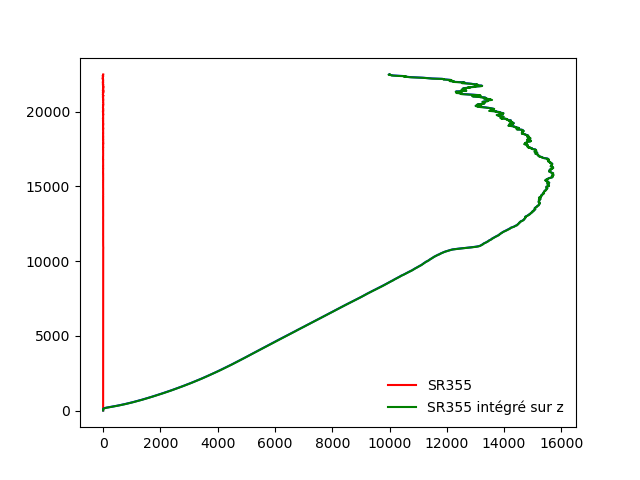

In [43]:
%matplotlib notebook
plt.plot(x[100,:1500], dtalt[:1500], color='r', label='SR355')
plt.plot(y[:1500], dtalt[:1500], color='b')
plt.plot(X3[:1500], dtalt[:1500], color='g', label='SR355 intégré sur z')
plt.legend(loc='best', frameon=False)
# plt.plot(X4[:1500], dtalt[:1500], color='b')
# plt.xlim(-5,600)


In [60]:
flags = (dt['flags'].sel(wavelength=355) == 0)

dt['calibrated'].sel(wavelength=355).where(dt['flags'].sel(wavelength=355) == 0, drop=False).plot(x='time', y='range', ylim=(0,20000), norm=LogNorm(vmin=1e-8))#.where(dt['flags'].sel(wavalength=355)==0, drop=True)

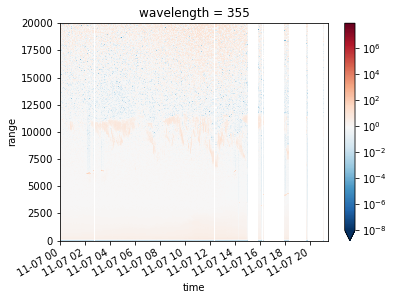

In [62]:
%matplotlib inline
dtsr = (dt['calibrated']/dt['simulated']).sel(wavelength=355).where(dt['flags'].sel(wavelength=355) == 0, drop=False)
dtsr.plot(x='time', y='range', ylim=(0,20000), norm=LogNorm(vmin=1e-8))

<ipython-input-16-815d077ac30c>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(result['latitude'].values, result['longitude'].values, result.values.T)


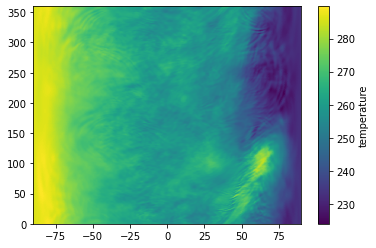

In [16]:
fig, ax = plt.subplots()
p = ax.pcolormesh(result['latitude'].values, result['longitude'].values, result.values.T)
plt.colorbar(p, ax=ax, label='temperature')

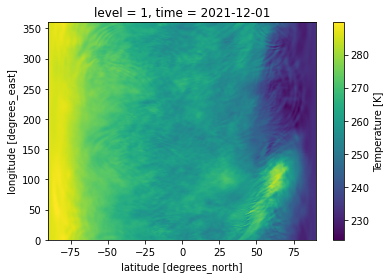

In [17]:
fig, ax = plt.subplots()
result.plot(x='latitude', y='longitude')

In [12]:
for subdir in sorted(Path('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/').iterdir()):
    subsubdir = sorted(subdir.iterdir())[0]
    print(sorted(subsubdir.glob('elic')))
    
def get_products_selected(main_path, day, product_name):
    product_path = Path(list_path).glob(f'**/{product_name}')
    def get_path_subdirectories(main_path, day):
        return list_path
    return product_path

[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200206/20200206sir8018/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200207/20200207sir8000/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200326/20200326sir1101/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200401/20200401sir1301/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200402/20200402sir0301/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200415/20200415sir8017/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200423/20200423sir8016/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200424/20200424sir8000/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200507/20200507sir8007/elic')]
[PosixPath('/homedata/nmpnguyen/IPRAL/SCC_produits/output/output/20200513/20200513sir8018/elic')]
[PosixPath('/homedat

-------------------------------------------

### Lecture du fichier des données brutes (LEVEL 1)

In [5]:
# DATA LEVEL 1
# il faut remplacer le chemin avec le votre
RAW_PATH = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/09/28/ipral_1a_Lz1R15mF30sPbck_v01_20180928_000000_1440.nc')

data1 = xr.open_dataset(RAW_PATH)
print(data1.variables)

Frozen({'time': <xarray.IndexVariable 'time' (time: 2287)>
array(['2018-09-27T23:59:34.000000000', '2018-09-28T00:00:04.000000000',
       '2018-09-28T00:00:34.000000000', ..., '2018-09-28T23:58:20.000000256',
       '2018-09-28T23:58:50.000000000', '2018-09-28T23:59:21.000000000'],
      dtype='datetime64[ns]')
Attributes:
    standard_name:  time
    bounds:         time_bnds, 'range': <xarray.IndexVariable 'range' (range: 4000)>
array([1.5000e+01, 3.0000e+01, 4.5000e+01, ..., 5.9970e+04, 5.9985e+04,
       6.0000e+04], dtype=float32)
Attributes:
    long_name:  range above ground level
    units:      m, 'time_bnds': <xarray.Variable (time: 2287, nv: 2)>
array([['2018-09-27T23:59:34.000000000', '2018-09-28T00:00:03.000000000'],
       ['2018-09-28T00:00:04.000000000', '2018-09-28T00:00:34.000000000'],
       ['2018-09-28T00:00:34.000000000', '2018-09-28T00:01:04.000000256'],
       ...,
       ['2018-09-28T23:58:20.000000256', '2018-09-28T23:58:50.000000000'],
       ['2018-09-28T23

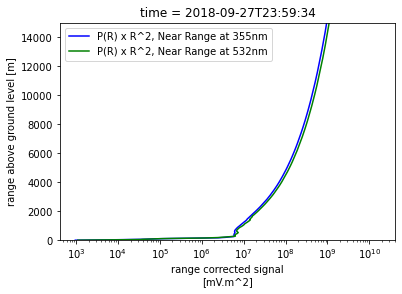

In [11]:
# plot 1 profil 
fig, ax = plt.subplots()
data1.isel(time=0)['rcs_12'].plot(y='range', ylim=(0, 15000), xscale='log', label='P(R) x R^2, Near Range at 355nm', color='b')
data1.isel(time=0)['rcs_16'].plot(y='range', ylim=(0, 15000), xscale='log', label='P(R) x R^2, Near Range at 532nm', color='g')
ax.legend()

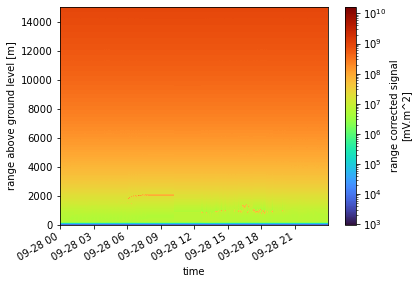

In [12]:
# plot tous les profils = 1 quicklook, 532nm, colorbar en log 
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
data1['rcs_12'].plot(y='range', x='time', ylim=(0, 15000), cmap='turbo', norm=LogNorm())

### Lecture du fichier des données calibrées (LEVEL 2)

In [13]:
CALIB_PATH = Path('/homedata/nmpnguyen/IPRAL/NETCDF/ipral_calib_v01_20180928_000000_1440.nc')

data2 = xr.open_dataset(CALIB_PATH)
data2

<xarray.Dataset>
Dimensions:                           (range: 4000, time: 2287)
Coordinates:
  * time                              (time) datetime64[ns] 2018-09-27T23:59:...
  * range                             (range) float32 15.0 30.0 ... 6e+04
Data variables: (12/15)
    Altitude                          (range) float32 ...
    Raw_AnalogNR_355                  (time, range) float64 ...
    Raw_AnalogNR_532                  (time, range) float64 ...
    Model_Pressure                    (time, range) float64 ...
    Model_Temperature                 (time, range) float64 ...
    Model_Molecular_Backscatter_355   (time, range) float64 ...
    ...                                ...
    Total_Calib_Attn_Backscatter_355  (time, range) float64 ...
    Total_Calib_Attn_Backscatter_532  (time, range) float64 ...
    Total_ScattRatio_355              (time, range) float64 ...
    Total_ScattRatio_532              (time, range) float64 ...
    C_355                             (time) float64 ...
    C_532                             (time) float64 ...
Attributes:
    Instrument_name:         IPSL HiPerformance multi-wavelength Raman Lidar
    Start_Datetime:          2018-09-27T23:59:34.000000000
    End_Datetime:            2018-09-28T23:59:21.000000000
    Latitude:                48.71799850463867
    Longitude:               2.2070000171661377
    Responsable_data:        N.M.Phuong Nguyen (phuong.nguyen@latmos.ipsl.fr)
    Responsable_instrument:  Christophe Pietras (christophe.pietras@lmd.ipsl.fr)

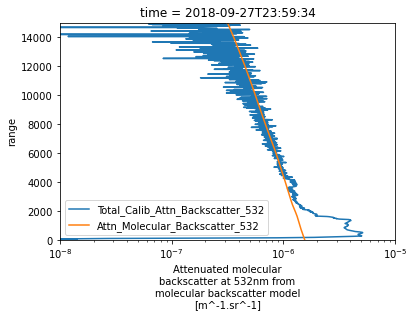

In [14]:
fig, ax = plt.subplots()
data2.isel(time=0)['Total_Calib_Attn_Backscatter_532'].plot(y='range', ylim=(0, 15000), xscale='log', xlim=(1e-8, 1e-5), label='Total_Calib_Attn_Backscatter_532')
data2.isel(time=0)['Attn_Molecular_Backscatter_532'].plot(y='range', ylim=(0, 15000), xscale='log', label='Attn_Molecular_Backscatter_532')
ax.legend()

In [16]:
data1.to_netcdf('ipral_1a_raw_v01_20180928_000000_1440.nc', 'w')

In [14]:
x = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles4_allatb355.nc')
y = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles4_allatb532.nc')

In [18]:
x['calibrated'][0,:]

<xarray.DataArray 'calibrated' (range: 666)>
array([ 1.960125e-06, -3.505533e-06,  7.026827e-07, ..., -1.682528e-06,
        3.853341e-06,  8.397533e-05])
Coordinates:
    time        datetime64[ns] 2018-02-21T12:00:00
  * range       (range) float32 5.01e+03 5.025e+03 ... 1.497e+04 1.498e+04
    wavelength  int64 355

AttributeError: 'function' object has no attribute 'ravel'

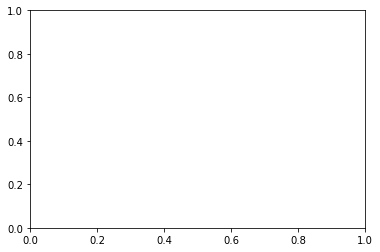

In [15]:
fig, ax = plt.subplots()
h = ax.hist2d(x.values.ravel(), y.values.ravel(), bins=100, range=[[-1, 40],[-1, 80]], norm=LogNorm())
plt.colorbar(h[3], ax=ax)
ax.set(xlabel='sr355_mesured', ylabel='sr532_mesured')

In [41]:

xarray 

xr.open_dataset('/bdd/CALIPSO/Lidar_L1/CAL_LID_L1.v4.11/2021/2021_08_07/CAL_LID_L1-Standard-V4-11.2021-08-07T12-53-14ZD.hdf')

<xarray.Dataset>
Dimensions:                                           (fakeDim0: 63375, fakeDim1: 1, fakeDim10: 63375, fakeDim100: 63375, fakeDim101: 1, fakeDim102: 63375, fakeDim103: 1, fakeDim104: 63375, fakeDim105: 1, fakeDim106: 63375, fakeDim107: 1, fakeDim108: 63375, fakeDim109: 1, fakeDim11: 1, fakeDim110: 63375, fakeDim111: 1, fakeDim112: 63375, fakeDim113: 1, fakeDim114: 63375, fakeDim115: 1, fakeDim116: 63375, fakeDim117: 1, fakeDim118: 63375, fakeDim119: 1, fakeDim12: 63375, fakeDim120: 63375, fakeDim121: 1, fakeDim122: 63375, fakeDim123: 1, fakeDim124: 63375, fakeDim125: 1, fakeDim126: 63375, fakeDim127: 1, fakeDim128: 63375, fakeDim129: 1, fakeDim13: 1, fakeDim130: 63375, fakeDim131: 1, fakeDim132: 63375, fakeDim133: 1, fakeDim134: 63375, fakeDim135: 1, fakeDim136: 63375, fakeDim137: 3, fakeDim138: 63375, fakeDim139: 3, fakeDim14: 63375, fakeDim140: 63375, fakeDim141: 3, fakeDim142: 63375, fakeDim143: 3, fakeDim144: 63375, fakeDim145: 1, fakeDim146: 63375, fakeDim147: 1, fakeDim148: 63375, fakeDim149: 1, fakeDim15: 1, fakeDim150: 63375, fakeDim151: 1, fakeDim152: 63375, fakeDim153: 1, fakeDim16: 63375, fakeDim17: 1, fakeDim18: 63375, fakeDim19: 1, fakeDim2: 63375, fakeDim20: 63375, fakeDim21: 1, fakeDim22: 63375, fakeDim23: 1, fakeDim24: 63375, fakeDim25: 1, fakeDim26: 63375, fakeDim27: 1, fakeDim28: 63375, fakeDim29: 1, fakeDim3: 1, fakeDim30: 63375, fakeDim31: 1, fakeDim32: 63375, fakeDim33: 1, fakeDim34: 63375, fakeDim35: 1, fakeDim36: 63375, fakeDim37: 1, fakeDim38: 63375, fakeDim39: 1, fakeDim4: 63375, fakeDim40: 63375, fakeDim41: 1, fakeDim42: 63375, fakeDim43: 1, fakeDim44: 63375, fakeDim45: 1, fakeDim46: 63375, fakeDim47: 1, fakeDim48: 63375, fakeDim49: 1, fakeDim5: 1, fakeDim50: 63375, fakeDim51: 1, fakeDim52: 63375, fakeDim53: 1, fakeDim54: 63375, fakeDim55: 1, fakeDim56: 63375, fakeDim57: 1, fakeDim58: 63375, fakeDim59: 1, fakeDim6: 63375, fakeDim60: 63375, fakeDim61: 583, fakeDim62: 63375, fakeDim63: 583, fakeDim64: 63375, fakeDim65: 1, fakeDim66: 63375, fakeDim67: 1, fakeDim68: 63375, fakeDim69: 1, fakeDim7: 1, fakeDim70: 63375, fakeDim71: 1, fakeDim72: 63375, fakeDim73: 1, fakeDim74: 63375, fakeDim75: 1, fakeDim76: 63375, fakeDim77: 583, fakeDim78: 63375, fakeDim79: 1, fakeDim8: 63375, fakeDim80: 63375, fakeDim81: 33, fakeDim82: 63375, fakeDim83: 33, fakeDim84: 63375, fakeDim85: 33, fakeDim86: 63375, fakeDim87: 33, fakeDim88: 63375, fakeDim89: 33, fakeDim9: 1, fakeDim90: 63375, fakeDim91: 2, fakeDim92: 63375, fakeDim93: 1, fakeDim94: 63375, fakeDim95: 1, fakeDim96: 63375, fakeDim97: 1, fakeDim98: 63375, fakeDim99: 1)
Dimensions without coordinates: fakeDim0, fakeDim1, fakeDim10, fakeDim100, fakeDim101, fakeDim102, fakeDim103, fakeDim104, fakeDim105, fakeDim106, fakeDim107, fakeDim108, fakeDim109, fakeDim11, fakeDim110, fakeDim111, fakeDim112, fakeDim113, fakeDim114, fakeDim115, fakeDim116, fakeDim117, fakeDim118, fakeDim119, fakeDim12, fakeDim120, fakeDim121, fakeDim122, fakeDim123, fakeDim124, fakeDim125, fakeDim126, fakeDim127, fakeDim128, fakeDim129, fakeDim13, fakeDim130, fakeDim131, fakeDim132, fakeDim133, fakeDim134, fakeDim135, fakeDim136, fakeDim137, fakeDim138, fakeDim139, fakeDim14, fakeDim140, fakeDim141, fakeDim142, fakeDim143, fakeDim144, fakeDim145, fakeDim146, fakeDim147, fakeDim148, fakeDim149, fakeDim15, fakeDim150, fakeDim151, fakeDim152, fakeDim153, fakeDim16, fakeDim17, fakeDim18, fakeDim19, fakeDim2, fakeDim20, fakeDim21, fakeDim22, fakeDim23, fakeDim24, fakeDim25, fakeDim26, fakeDim27, fakeDim28, fakeDim29, fakeDim3, fakeDim30, fakeDim31, fakeDim32, fakeDim33, fakeDim34, fakeDim35, fakeDim36, fakeDim37, fakeDim38, fakeDim39, fakeDim4, fakeDim40, fakeDim41, fakeDim42, fakeDim43, fakeDim44, fakeDim45, fakeDim46, fakeDim47, fakeDim48, fakeDim49, fakeDim5, fakeDim50, fakeDim51, fakeDim52, fakeDim53, fakeDim54, fakeDim55, fakeDim56, fakeDim57, fakeDim58, fakeDim59, fakeDim6, fakeDim60, fakeDim61, fakeDim62, fakeDim63, fakeDim64, fakeDim65, fakeDim66, fakeDim67, fakeDim68, fakeDim69,

In [42]:
xr.__version__

'0.17.0'